## 3. NCC test
Identify causal relations on MSCOCO dataset

### 3-1. MSCOCO dataset
subset of 99,309 MSCOCO images belonging to 20 Pascal object categories. 
resize (224x224, 짧은 쪽이 224 pixel로 rescale하고 224x224 centercrop).

In [1]:
import json
import numpy as np
import pylab
import matplotlib.pyplot as plt
import tqdm
import skimage.io as io
from PIL import Image
from pycocotools.coco import COCO
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms as T
import torch.nn.functional as F
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image

c:\Users\yeong\miniconda3\envs\NCC\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# object categories in pascal voc
categories = [
    'airplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 
    'dining table', 'dog', 'horse', 'motorcycle', 'person', 'potted plant', 'sheep', 'couch', 'train', 'tv'
]
# 16 matched categories in coco dataset
# no matched in coco: aeroplane, motorbike, sofa, television
# aeroplane - airplane, motorbike - motorcycle, sofa - couch, television - tv

In [3]:
dataDir = 'data/coco'
dataType='train2014' #'val2014'
annFile='{}/annotations/instances_{}.json'.format(dataDir, dataType)
# initialize COCO api for instance annotations
coco=COCO(annFile)
# categories
cats = coco.loadCats(coco.getCatIds())
coco_cats = {cat['id']: cat['name'] for cat in cats}

# get all images containing given categories, select one at random
idx = 0
dataset = []
for cat in categories:
    catIds = coco.getCatIds(catNms=cat)
    imgIds = coco.getImgIds(catIds=catIds)
    print(f'{cat}: {len(imgIds)}')
    for imgId in imgIds:
        annIds = coco.getAnnIds(imgIds=imgId, catIds=catIds, iscrowd=None)
        anns = coco.loadAnns(annIds)
        label = {'imgId': imgId, 'categories': [], 'bbox': []}
        for i, ann in enumerate(anns):
            label['categories'].append(coco_cats[ann['category_id']])
            label['bbox'].append(ann['bbox'])
        
        img_file_name = coco.loadImgs(imgId)[0]['file_name']
        label['file_name'] = img_file_name
        
        # dataset[idx] = label
        dataset.append(label)
        idx += 1

num_imgs = len(dataset)
print(f'Number of images: {len(dataset)}')

# dataType1 = dataType.reshape('2014','')
# with open(f'data/coco/{dataType1}Ids.txt', 'w') as f:
#     json.dump(dataset, f, indent=4)

loading annotations into memory...
Done (t=24.85s)
creating index...
index created!
airplane: 2243
bicycle: 2287
bird: 2241
boat: 2098
bottle: 5968
bus: 2791
car: 8606
cat: 2818
chair: 8950
cow: 1389
dining table: 8378
dog: 3041
horse: 2068
motorcycle: 2442
person: 45174
potted plant: 3084
sheep: 1105
couch: 3170
train: 2464
tv: 3191
Number of images: 113508


In [4]:
def show_img(imgid, category):
    # load and display instance annotations
    fig, ax = plt.subplots(figsize=(10, 8))
    # load image
    img = coco.loadImgs(imgid)[0]
    I = io.imread(img['coco_url'])
    ax.imshow(I); plt.axis('off')
    # load annotations
    annIds = coco.getAnnIds(imgIds=img['id'], 
                            catIds=coco.getCatIds(catNms=category), 
                            iscrowd=None)
    anns = coco.loadAnns(annIds)
    coco.showAnns(anns, draw_bbox=True)
    for i, ann in enumerate(anns):
        ax.text(anns[i]['bbox'][0], anns[i]['bbox'][1], coco_cats[anns[i]['category_id']], style='italic', 
                bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})

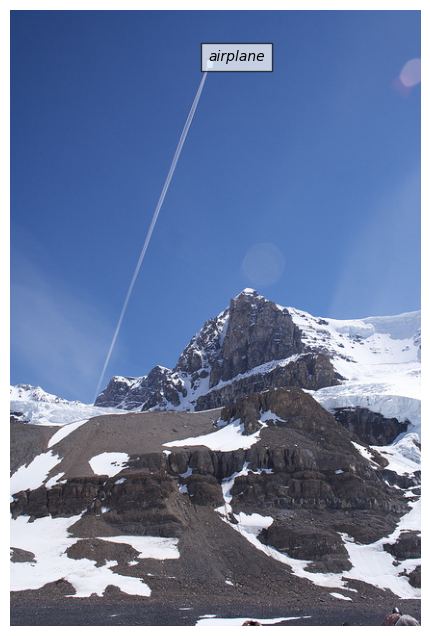

In [5]:
show_img(393221, 'airplane')

In [134]:
# MSCOCO image (bbox + label)
class COCODataset(Dataset):
    def __init__(self, dataDir='data/coco', transform=None):
        # dataDir = dataDir
        dataType='train2014'
        # annFile='{}/annotations/instances_{}.json'.format(dataDir, dataType)
        self.img_path = f'{dataDir}/{dataType}/'

        # initialize COCO api for instance annotations
        # self.coco=COCO(annFile)

        # json
        with open(f'{dataDir}/trainIds.txt', 'r') as f:
            self.dataset = json.load(f) # 'img_id', 'bbox', 'anns'
        
        # transform
        self.transform = transform

    def __getitem__(self, index):
        data = self.dataset[index]
        
        org_img = read_image(self.img_path+data['file_name'])
        
        cats = torch.tensor([categories.index(x) for x in data['categories']])
        
        # img = draw_bounding_boxes(img, bboxs)
        mask = torch.zeros(org_img.shape[1:], dtype=int)
        for bbox in data['bbox']:
            x1, x2 = int(bbox[1]), int(bbox[1]+bbox[3])+1
            y1, y2 = int(bbox[0]), int(bbox[0]+bbox[2])+1
            mask[x1:x2,y1:y2] = 1

        mask = torch.tensor(mask>0, dtype=torch.uint8)
        
        objectImg = torch.where(mask>0, org_img, mask)
        contextImg = torch.where(mask>0, mask, org_img)
        
        if self.transform is not None:
            orgImg = self.transform(org_img)
            objectImg = self.transform(objectImg)
            contextImg = self.transform(contextImg)
        
        return orgImg, objectImg, contextImg, cats
    
    def __len__(self):
        return len(self.dataset)

In [ ]:
transform = T.Compose([
    # All images are rescaled to ensure that 
    # their shorter side is 224 pixels long, 
    # then cropped to the central 224×224 square
    T.ToPILImage(),
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor()
])
dataset = COCODataset()
dataloader = DataLoader(dataset, batch_size=1)

### 3-2. Model for object features

In [3]:
from torch import nn
from torchvision.models import resnet18
import tqdm

In [4]:
def feature_extractor():
    model_ft = resnet18(pretrained=True)
    # finetune
    for param in model_ft.parameters():
        param.requires_grad = False
    # modify classifier
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Flatten()
    # features = model_ft._modules.get('avgpool')
    return model_ft

In [5]:
class Classifier(nn.Module):
    #  train on Pascal VOC 2012 dataset!!
    def __init__(self, in_features=512, hidden_dim=512):
        super(Classifier, self).__init__()
        self.layer1 = nn.Linear(in_features, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, 20)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.classifier(x)
        # softmax
        return x

In [6]:
class NCC_Classifier(nn.Module):
    def __init__(self, num_classes=2, in_features=2, hidden_dim=100):
        super(NCC_Classifier, self).__init__()
        
        self.emb_layer1 = nn.Sequential(*[
            nn.Linear(in_features, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.25)
        ])
        
        self.emb_layer2 = nn.Sequential(*[
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.25)
        ])

        self.classifier1 = nn.Sequential(*[
            nn.Linear(hidden_dim, hidden_dim),
            # nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.25)
        ])
        
        self.classifier2 = nn.Sequential(*[
            nn.Linear(hidden_dim, hidden_dim),
            # nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.25)
        ])

        self.classifier = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x, evalu=False):
        if not evalu:
            x = self.emb_layer1(x)
            x = self.emb_layer2(x)
            # x = torch.stack([x[i:i+N].mean(axis=0) for i in range(0,N+1,N)])
            x = x.mean(axis=0).reshape(1,-1)
        
        x = self.classifier1(x)
        x = self.classifier2(x)
        x = self.classifier(x)
        # softmax
        return x

In [7]:
device = 'cpu'

resnet = feature_extractor().to(device)

classifier = Classifier()
classifier.load_state_dict(torch.load('results/object_classifier_10.pt'))
classifier = classifier.to(device)

NCC_classifier = NCC_Classifier()
NCC_classifier.load_state_dict(torch.load('results/model_59.pt'))
NCC_classifier = NCC_classifier.to(device)

In [8]:
resnet.eval()
classifier.eval()
NCC_classifier.eval()

NCC_Classifier(
  (emb_layer1): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
  )
  (emb_layer2): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
  )
  (classifier1): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
  )
  (classifier2): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
  )
  (classifier): Linear(in_features=100, out_features=2, bias=True)
)

### 3-3. Test

In [9]:
import seaborn as sns
import pandas as pd
import tqdm

In [10]:
dataDir = 'data/coco'
dataType='train2014' #'val2014'
img_path = f'{dataDir}/{dataType}/'
annFile='{}/annotations/instances_{}.json'.format(dataDir, dataType)
# initialize COCO api for instance annotations
coco=COCO(annFile)
# categories
cats = coco.loadCats(coco.getCatIds())
coco_cats = {cat['id']: cat['name'] for cat in cats if cat['name'] in categories}
coco_cats_idx = {v: i for i,(k,v) in enumerate(coco_cats.items())}

loading annotations into memory...
Done (t=13.24s)
creating index...
index created!


In [11]:
transform = T.Compose([
    # All images are rescaled to ensure that 
    # their shorter side is 224 pixels long, 
    # then cropped to the central 224×224 square
    T.ToPILImage(),
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor()
])
batch_size = 32

In [12]:
# get all images containing given categories, select one at random
dataset = []
object_feature_ratio_lst = {}
context_feature_ratio_lst = {}

for cat_idx, cat in enumerate(categories):
    # get cat images
    catIds = coco.getCatIds(catNms=cat)
    imgIds = coco.getImgIds(catIds=catIds)
    print(f'{cat}: {len(imgIds)}')

    NCC_causal_scores = torch.empty((0,512))
    NCC_anticausal_scores = torch.empty((0,512))

    object_feature_ratio = torch.empty((0,512))
    context_feature_ratio = torch.empty((0,512))

    for batch_img_idx in tqdm.tqdm(range(0, len(imgIds), batch_size)):
        imgBatch = imgIds[batch_img_idx: batch_img_idx+batch_size]

        f = torch.empty((0,512))
        c_k = torch.empty((0))

        f_o = torch.empty((0,512))
        f_c = torch.empty((0,512))

        for imgId in imgBatch:
            # get annotations
            annIds = coco.getAnnIds(imgIds=imgId, catIds=catIds, iscrowd=None)
            anns = coco.loadAnns(annIds)
            labels, bboxs = [], []
            for i, ann in enumerate(anns):
                if coco_cats[ann['category_id']] != cat:
                    print('different!!', coco_cats[ann['category_id']])
                labels.append(coco_cats_idx[coco_cats[ann['category_id']]])
                bboxs.append(ann['bbox'])
            labelId = coco_cats_idx[coco_cats[ann['category_id']]]
            
            # get image
            img_file_name = coco.loadImgs(imgId)[0]['file_name']
            orgImg = read_image(img_path+img_file_name)
            if orgImg.shape[0] == 1:
                orgImg = orgImg.repeat(3, 1, 1) # 21 gray scale images
            
            # img = draw_bounding_boxes(img, bboxs)
            mask = torch.zeros(orgImg.shape[1:], dtype=int)
            for bbox in bboxs:
                x1, x2 = int(bbox[1]), int(bbox[1]+bbox[3])+1
                y1, y2 = int(bbox[0]), int(bbox[0]+bbox[2])+1
                mask[x1:x2,y1:y2] = 1

            # mask = torch.tensor(mask>0, dtype=torch.uint8)
            mask = (mask>0).clone().detach().type(torch.uint8)
            
            objectImg = torch.where(mask>0, orgImg, mask)
            contextImg = torch.where(mask>0, mask, orgImg)
            
            if transform is not None:
                orgImg = transform(orgImg).unsqueeze(0)
                objectImg = transform(objectImg).unsqueeze(0)
                contextImg = transform(contextImg).unsqueeze(0)
            
            # get features
            features = resnet(orgImg)
            o_features = resnet(objectImg)
            c_features = resnet(contextImg)
            
            dim_features = o_features.shape[1]
            
            logodds = classifier(features)
            
            f = torch.cat((f, features.detach().data))  # (B, 512)
            c_k = torch.cat((c_k, logodds[:, labelId].detach().data))  # (B)

            f_o = torch.cat((f_o, o_features.detach().data))
            f_c = torch.cat((f_c, c_features.detach().data))

        # get NCC score
        NCC_causal_score_batch = torch.empty((dim_features), dtype=float)  # (512)
        NCC_anticausal_score_batch = torch.empty((dim_features), dtype=float)  # (512)
        s_o_l_batch = torch.empty((dim_features), dtype=float)
        s_c_l_batch = torch.empty((dim_features), dtype=float)
        for idx_feature in range(dim_features):
            f_l = f[:,idx_feature]
            # causal score
            score = NCC_classifier(torch.cat((f_l.unsqueeze(1), c_k.unsqueeze(1)), dim=1), evalu=False)
            NCC_causal_score_batch[idx_feature] = score[:,1]
            # anticausal score
            score = NCC_classifier(torch.cat((c_k.unsqueeze(1), f_l.unsqueeze(1)), dim=1), evalu=False)
            NCC_anticausal_score_batch[idx_feature] = score[:,1]

            # object/context ratio
            denominator = torch.abs(f_l).sum(dim=0)
            s_o_l = torch.abs(f_c[:,idx_feature] - f_l).sum(dim=0) / denominator
            s_c_l = torch.abs(f_o[:,idx_feature] - f_l).sum(dim=0) / denominator
            # print(s_o_l.shape)
            s_o_l_batch[idx_feature] = s_o_l
            s_c_l_batch[idx_feature] = s_c_l
        
        NCC_causal_scores = torch.cat((NCC_causal_scores, NCC_causal_score_batch.unsqueeze(0)), dim=0)  # (1, 512)
        NCC_anticausal_scores = torch.cat((NCC_anticausal_scores, NCC_anticausal_score_batch.unsqueeze(0)), dim=0)  # (1, 512)
        
        object_feature_ratio = torch.cat((object_feature_ratio, s_o_l_batch.unsqueeze(0)), dim=0)
        context_feature_ratio = torch.cat((context_feature_ratio, s_c_l_batch.unsqueeze(0)), dim=0)
        
    # top 1% causal/anticausal features
    NCC_scores_mean = NCC_causal_scores.mean(dim=0)
    top_causal_features = torch.argsort(NCC_scores_mean, descending=True)[:5]

    NCC_scores_mean = NCC_anticausal_scores.mean(dim=0)
    top_anticausal_features = torch.argsort(NCC_scores_mean, descending=True)[:5]    

    # object/context feature scores associated to the top 1% causal/anticausal feature scores
    object_feature_ratio_causal = object_feature_ratio[:,top_causal_features]
    context_feature_ratio_causal = context_feature_ratio[:,top_causal_features]
    
    object_feature_ratio_anticausal = object_feature_ratio[:,top_anticausal_features]
    context_feature_ratio_anticausal = context_feature_ratio[:,top_anticausal_features]
    
    # save data
    objectFeatures = pd.DataFrame(torch.cat((object_feature_ratio_anticausal.mean(dim=1).unsqueeze(1), object_feature_ratio_causal.mean(dim=1).unsqueeze(1)), dim=1), columns=['top anticausal','top causal'])
    contextFeatures = pd.DataFrame(torch.cat((object_feature_ratio_anticausal.mean(dim=1).unsqueeze(1), object_feature_ratio_causal.mean(dim=1).unsqueeze(1)), dim=1), columns=['top anticausal','top causal'])
    
    object_feature_ratio_lst[cat] = objectFeatures
    context_feature_ratio_lst[cat] = contextFeatures

airplane: 2243


  0%|          | 0/71 [00:00<?, ?it/s]c:\Users\yeong\miniconda3\envs\NCC\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 71/71 [10:39<00:00,  9.00s/it]


bicycle: 2287


100%|██████████| 72/72 [10:05<00:00,  8.41s/it]


bird: 2241


  4%|▍         | 3/71 [00:20<07:59,  7.06s/it]

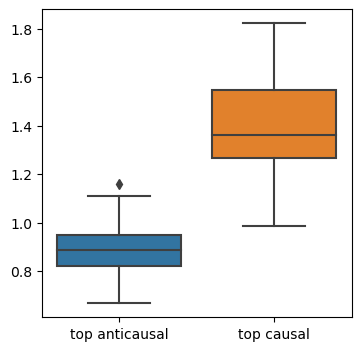

In [41]:
# object features are related to anticausal features: 
# top 1% anticausal features exhibit a higher object-feature ratio than the top 1% causal features.
plt.figure(figsize=(4,4))
sns.boxplot(data=object_feature_ratio_lst['airplane'])
plt.show()